[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/seap-udea/multimin/blob/master/examples/multimin_asteroids_application.ipynb)

<p align="left"><img src="https://raw.githubusercontent.com/seap-udea/multimin/master/docs/multimin-logo-white.webp" width="600" /></p>

# Asteroid orbital elements: an application of **multimin**

This notebook goes deeper into the **multimin** module: loading data, building MoGs, and fitting with bounds and multiple components for a particular case, the orbital elements of asteroids.

## Installation

If you're running this in Google Colab or need to install the package, uncomment and run the following cell:

In [1]:
import os
import matplotlib.pyplot as plt
os.makedirs('gallery', exist_ok=True)
try:
    from google.colab import drive
    %pip install -Uq multimin
except ImportError:
    print("Not running in Colab, skipping installation")
    %load_ext autoreload
    %autoreload 2
!mkdir -p gallery/

# Uncomment to install from GitHub (development version)
# !pip install git+https://github.com/seap-udea/MultiMin.git

Not running in Colab, skipping installation


## Load the package

Import **multimin** and other required libraries:

In [2]:
import pandas as pd
import numpy as np
import multimin as mn
import warnings
%matplotlib inline

warnings.filterwarnings("ignore")

figprefix="asteroids"

Welcome to MultiMin v0.11.2. ¡Al infinito y más allá!


## Asteroid data

**multimin** was originally developed to solve the problem of describing the distribution of asteroids in the space of orbital elements. This is a true scientific application of the package that illustrate the power of the methods and the versatility of the numerical methods provided by the package.

Load the dataset (e.g. orbital elements):

In [3]:
# NEA Data
df_neas=pd.read_json(mn.Util.get_data("nea_data.json.gz"))

# Let's filter 10000 asteroids
df_neas=df_neas.sample(10000)

# Let's select the columns we want to fit
df_neas["q"]=df_neas["a"]*(1-df_neas["e"])
data_neas=np.array(df_neas[["q","e","i","Node","Peri","M"]])

Let's see the data:

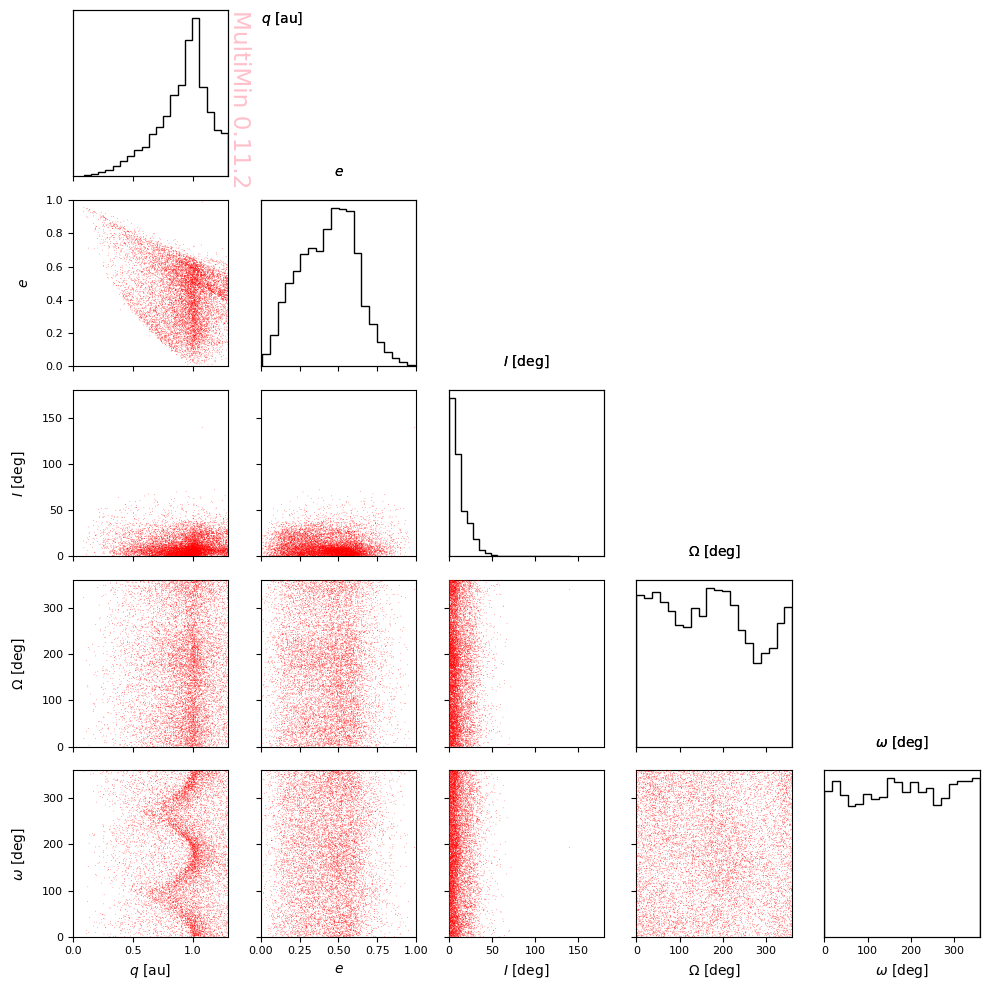

In [4]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
    i=dict(label=r"$I$ [deg]",range=[0.0,180.0]),
    W=dict(label=r"$\Omega$ [deg]",range=[0,360]),
    w=dict(label=r"$\omega$ [deg]",range=[0,360]),
)
G=mn.MultiPlot(properties,figsize=2,marginals=True)

sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.sample_scatter(data_neas,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas.png')


### Non-trivially correlated properties

The only elements with a non-trivial distribution are $q, e, I$. Let's study the distribution, for instance, of the $q$ and $e$. For this purpose we need to create a subset:

In [5]:
data_neas_qe=np.array(df_neas[["q","e"]])

And plot it:

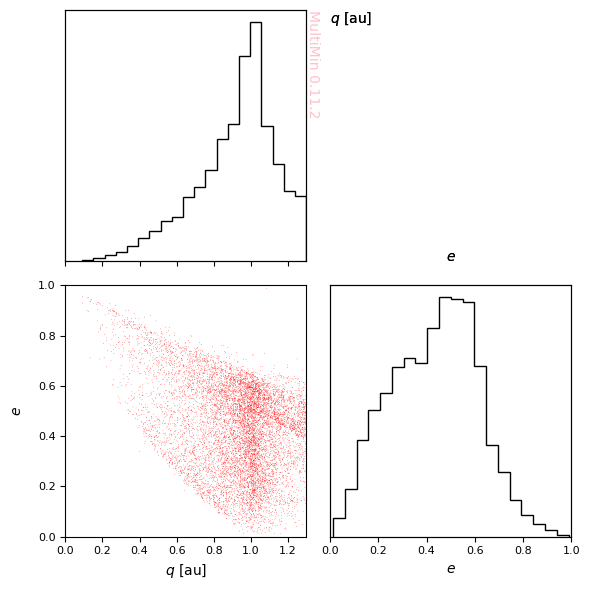

In [6]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)

G=mn.MultiPlot(properties,figsize=3,marginals=True)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.sample_scatter(data_neas_qe,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas_qe.png')

Now we will proceed to fit the data against a singled truncated distribution:

In [7]:
t = mn.Util.el_time(0)
F_qe_1 = mn.FitMoG(data=data_neas_qe, ngauss=1, domain=[[0,1.3], [0, 1]])
F_qe_1.fit_data(progress=False)
t = mn.Util.el_time()
print(f"-log(L)/N = {F_qe_1.solution.fun/len(data_neas_qe)}")

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1.3], [0, 1]]
Log-likelihood per point (-log L/N): 0.3069266643132097


FitMoG.fit_data executed in 0.17796087265014648 seconds
Elapsed time since last call: 214.859 ms
-log(L)/N = -0.5420059684331126


And check the fit result:

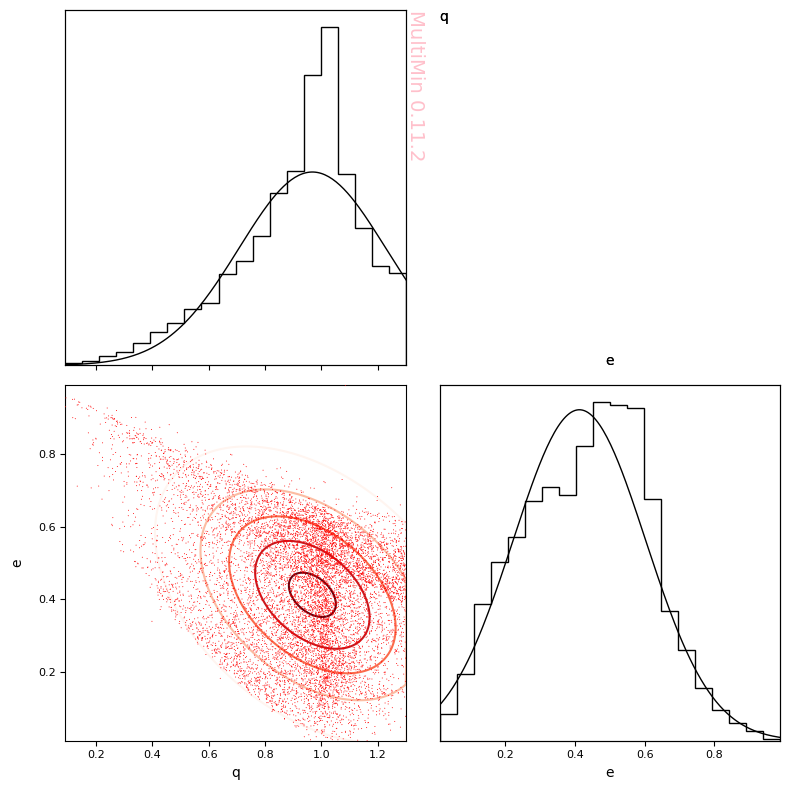

In [8]:
# properties: list of names or dict like MultiPlot (e.g. dict(q=dict(label=r"$q$", range=None), ...))
properties=["q","e"]
pargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
cargs=dict()
G=F_qe_1.plot_fit(
    properties=properties,
    #pargs=hargs,
    pargs=None,
    sargs=sargs,
    cargs=cargs,
    figsize=4,
    marginals=True
)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_1gauss.png')


In [9]:
F_qe_1.mog.tabulate()

w      mu_1      mu_2   sigma_1   sigma_2   rho_12
component                                                      
1          1.0  0.968082  0.412716  0.260405  0.190066 -0.41963

We can do it better increasing the number of normals:

In [10]:
t = mn.Util.el_time(0)
F = mn.FitMoG(data=data_neas_qe, ngauss=5, domain=[[0,1.3], [0, 1]])
F.fit_data(advance=50)
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(data_neas_qe)}")

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 2
Number of dimensions: 10
Number of samples: 10000
Domain: [[0, 1.3], [0, 1]]
Log-likelihood per point (-log L/N): 0.24592579605996193


Iterations:
Iter 0:
	Vars: [-1.5, -1.3, -1.3, -1.3, -1.5, 0.48, 0.14, 0.82, 0.31, 0.96, 0.45, 1, 0.55, 1.2, 0.71, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, 0.71, 0.64, 0.72, 0.41, 1.1]
	LogL/N: 2.036174199226079


Iter 50:
	Vars: [-2.3, -1.1, -0.62, -1.2, -1.8, 0.62, 0.34, 0.97, 0.49, 0.99, 0.25, 1.1, 0.54, 0.99, 0.49, -4.3, -4.4, -3.7, -4.5, -4.4, -4.5, -3.1, -4.1, -4.4, -4.6, -2.1, -1.8, -0.48, -3.7, 0.55]
	LogL/N: -0.7086065131329529


Iter 100:
	Vars: [-2.1, -0.98, -0.98, -0.95, -1.9, 0.7, 0.26, 0.92, 0.41, 1, 0.27, 1.2, 0.48, 1, 0.54, -4.3, -4.5, -3.6, -4.2, -4.7, -4.3, -3, -4, -4.6, -5.1, -2.6, -1.6, -0.55, -3.8, 0.32]
	LogL/N: -0.7178703388400184


Iter 150:
	Vars: [-2.3, -0.6, -1.2, -0.69, -2.1, 0.73, 0.23, 0.91, 0.36, 1, 0.31, 1.2, 0.46, 1, 0.56, -4.2, -4.5, -3.7, -4.2, -5.1, -4.2, -3, -3.9, -4.3, -5.3, -3.1, -1.6, -0.49, -3.7, -0.025]
	LogL/N: -0.722129782614954


Iter 200:
	Vars: [-2.4, -0.47, -1.2, -0.7, -2.2, 0.72, 0.23, 0.92, 0.35, 1, 0.32, 1.2, 0.49, 1, 0.57, -4.1, -4.5, -3.7, -4.2, -5.1, -4.1, -3.1, -4, -4.1, -5.3, -3.4, -1.6, -0.39, -3.6, -0.13]
	LogL/N: -0.7227668905384268


Iter 250:
	Vars: [-2.5, -0.54, -1.1, -0.65, -2.1, 0.71, 0.23, 0.91, 0.35, 1, 0.32, 1.1, 0.49, 1, 0.57, -4.2, -4.5, -3.7, -4.2, -5.1, -4.2, -3.1, -4, -4.2, -5.3, -3.5, -1.6, -0.37, -3.6, -0.2]
	LogL/N: -0.722906696361148


Iter 300:
	Vars: [-2.5, -0.53, -1.2, -0.62, -2.1, 0.71, 0.23, 0.91, 0.34, 1, 0.32, 1.1, 0.49, 1, 0.57, -4.2, -4.5, -3.7, -4.2, -5.1, -4.2, -3.1, -4, -4.2, -5.3, -3.6, -1.6, -0.37, -3.5, -0.28]
	LogL/N: -0.7229453277945526


Iter 350:
	Vars: [-2.6, -0.47, -1.2, -0.62, -2.1, 0.7, 0.23, 0.91, 0.34, 1, 0.32, 1.1, 0.5, 1, 0.57, -4.2, -4.5, -3.7, -4.2, -5.1, -4.2, -3.1, -4, -4.2, -5.3, -3.8, -1.5, -0.37, -3.5, -0.45]
	LogL/N: -0.7229990100528123


Iter 400:
	Vars: [-2.6, -0.45, -1.2, -0.61, -2, 0.7, 0.23, 0.91, 0.34, 1, 0.32, 1.1, 0.49, 1.1, 0.57, -4.2, -4.5, -3.7, -4.2, -5.1, -4.2, -3.1, -4, -4.2, -5.3, -3.9, -1.5, -0.36, -3.5, -0.58]
	LogL/N: -0.7230151501588397


Iter 446:
	Vars: [-2.6, -0.46, -1.2, -0.62, -2, 0.7, 0.23, 0.91, 0.34, 1, 0.32, 1.1, 0.49, 1.1, 0.57, -4.2, -4.5, -3.7, -4.2, -5.1, -4.2, -3.1, -4, -4.1, -5.3, -3.9, -1.5, -0.37, -3.5, -0.72]
	LogL/N: -0.7230296893084674
FitMoG.fit_data executed in 28.181262016296387 seconds
Elapsed time since last call: 28.2233 s
-log(L)/N = -0.7230296893084674


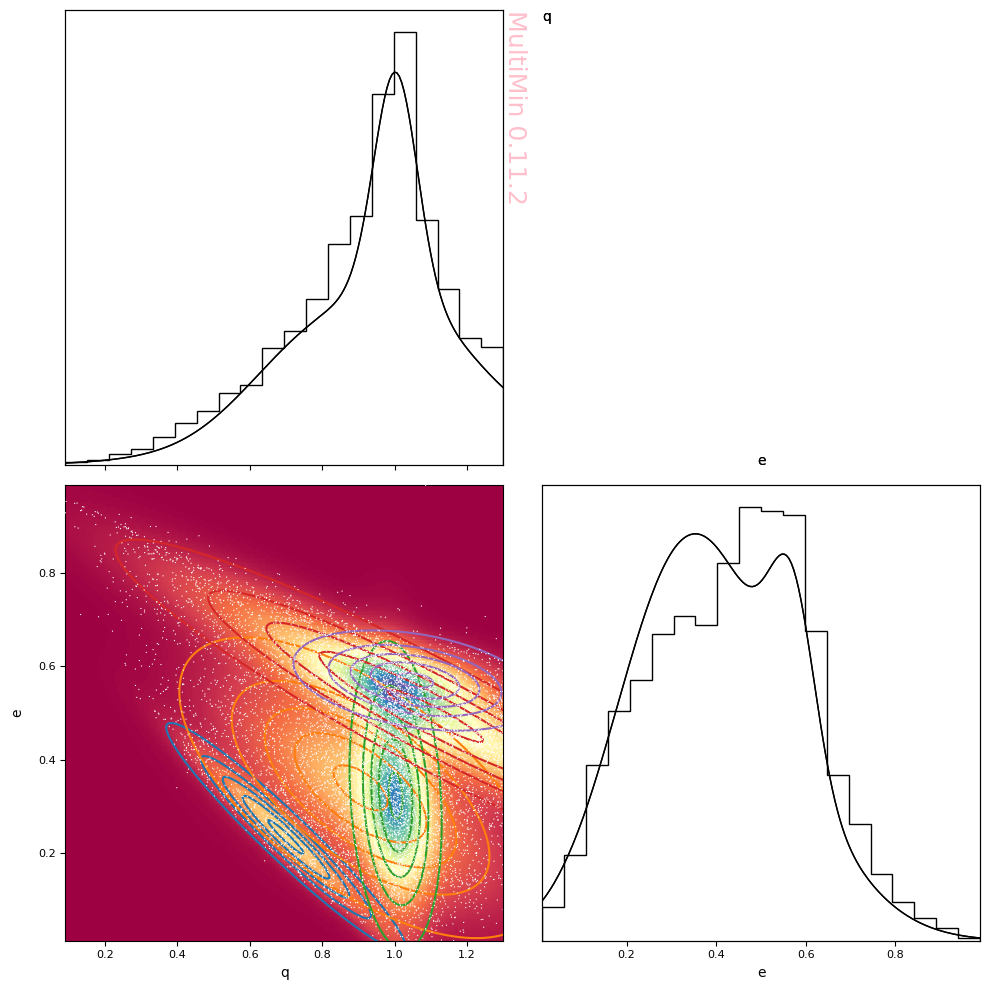

In [11]:
properties = ["q","e"]
sargs = dict(s=0.8,edgecolor='None',color='w')
pargs = dict(cmap='Spectral')
cargs = dict(decomp=True, legend=False)
G=F.plot_fit(
    properties=properties,
    pargs=pargs,
    sargs=sargs,
    cargs=cargs,
    figsize=5,
    marginals=True
)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss_decomposition.png')

Another way of comparing is to generate a sample with the fitted distribution and compare it with the original one:

In [12]:
neas_sample = F.mog.rvs(len(data_neas_qe))

MixtureOfGaussians.rvs executed in 1.221534013748169 seconds


And plot it:

Text(0.5, 1.0, 'Original data')

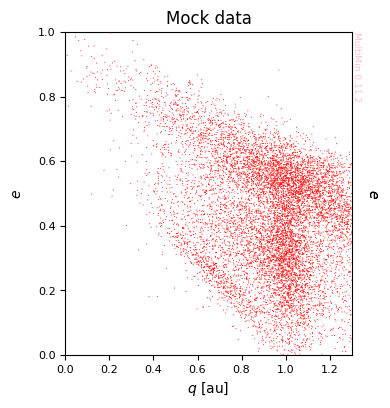

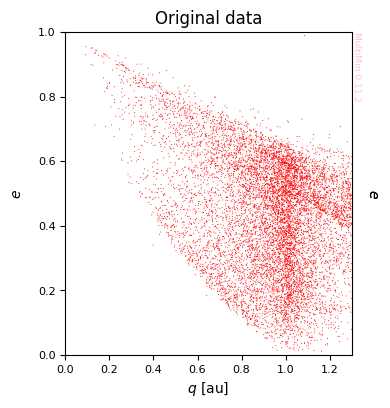

In [13]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
# Mock data
G = mn.MultiPlot(properties,figsize=4)
G.sample_scatter(neas_sample,**sargs)
G.axs[0][0].set_title("Mock data")
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss_sample.png')
# True data
G=mn.MultiPlot(properties,figsize=4)
scatter=G.sample_scatter(data_neas_qe,**sargs)
G.axs[0][0].set_title("Original data")


Let's see the fit function:

In [14]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
table = F.mog.tabulate(properties=properties)
table

w      mu_q      mu_e   sigma_q   sigma_e    rho_qe
component                                                            
2          0.335461  0.905865  0.339735  0.233117  0.150327 -0.638605
4          0.303902  1.112832  0.494163  0.411581  0.176253 -0.940484
3          0.200929  1.002469  0.323179  0.059151  0.154468 -0.181035
5          0.101112  1.056175  0.569920  0.156332  0.050081 -0.346080
1          0.058596  0.699890  0.233712  0.154038  0.114269 -0.961515

In [15]:
function, mog = F.mog.get_function(properties=properties)

import numpy as np
from multimin import Util

def mog(X):

    a = [0.0, 0.0]
    b = [1.3, 1.0]

    mu1_q = 0.69989
    mu1_e = 0.233712
    mu1 = [mu1_q, mu1_e]
    Sigma1 = [[0.023728, -0.016924], [-0.016924, 0.013057]]
    Z1 = 0.979583
    n1 = Util.tnmd(X, mu1, Sigma1, a, b, Z=Z1)

    mu2_q = 0.905865
    mu2_e = 0.339735
    mu2 = [mu2_q, mu2_e]
    Sigma2 = [[0.054344, -0.022379], [-0.022379, 0.022598]]
    Z2 = 0.948362
    n2 = Util.tnmd(X, mu2, Sigma2, a, b, Z=Z2)

    mu3_q = 1.002469
    mu3_e = 0.323179
    mu3 = [mu3_q, mu3_e]
    Sigma3 = [[0.003499, -0.001654], [-0.001654, 0.02386]]
    Z3 = 0.981784
    n3 = Util.tnmd(X, mu3, Sigma3, a, b, Z=Z3)

    mu4_q = 1.112832
    mu4_e = 0.494163
    mu4 = [mu4_q, mu4_e]
    Sigma4 = [[0.169399, -0.068225], [-0.068225, 0.031065]]
    Z4 = 0.671382
    n4 = Util.tnmd(X, mu4, Sigma4, a, b, Z=Z4)

    mu5_q = 1.056175
    mu5_e = 0.56992
    mu5 = [mu5_q, mu5_e]
    Sigma5 = [[0.02444, -0.00271], [-0.00271, 0.002508]]
    Z5 = 

### Fitting other pair of properties

Fitting $q$ and $I$:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1.3], [0, 180]]
Log-likelihood per point (-log L/N): 130.8794279820832


FitMoG.fit_data executed in 0.21601486206054688 seconds
-log(L)/N = 3.440885016885199


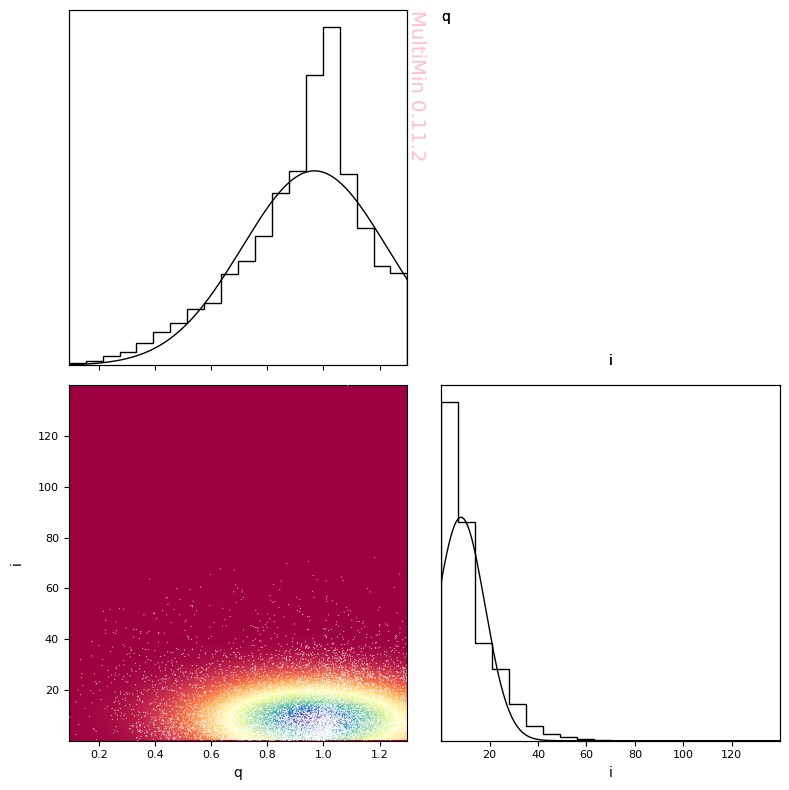

In [16]:
data_neas_qi=np.array(df_neas[["q","i"]])
F_qi_1 = mn.FitMoG(data=data_neas_qi, ngauss=1, domain=[[0,1.3], [0, 180]])
F_qi_1.fit_data(progress=False)
print(f"-log(L)/N = {F_qi_1.solution.fun/len(data_neas_qi)}")

properties=["q","i"]
sargs=dict(s=0.5,edgecolor='None',color='w')
pargs=dict(cmap='Spectral')
G=F_qi_1.plot_fit(properties=properties,pargs=pargs,sargs=sargs,figsize=4,marginals=True)
plt.savefig(f'gallery/{figprefix}_fit_result_qi_1gauss.png')

Fitting $e$ and $I$:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1], [0, 180]]
Log-likelihood per point (-log L/N): 133.65543285556114
FitMoG.fit_data executed in 0.1379380226135254 seconds
-log(L)/N = 3.284645348500123


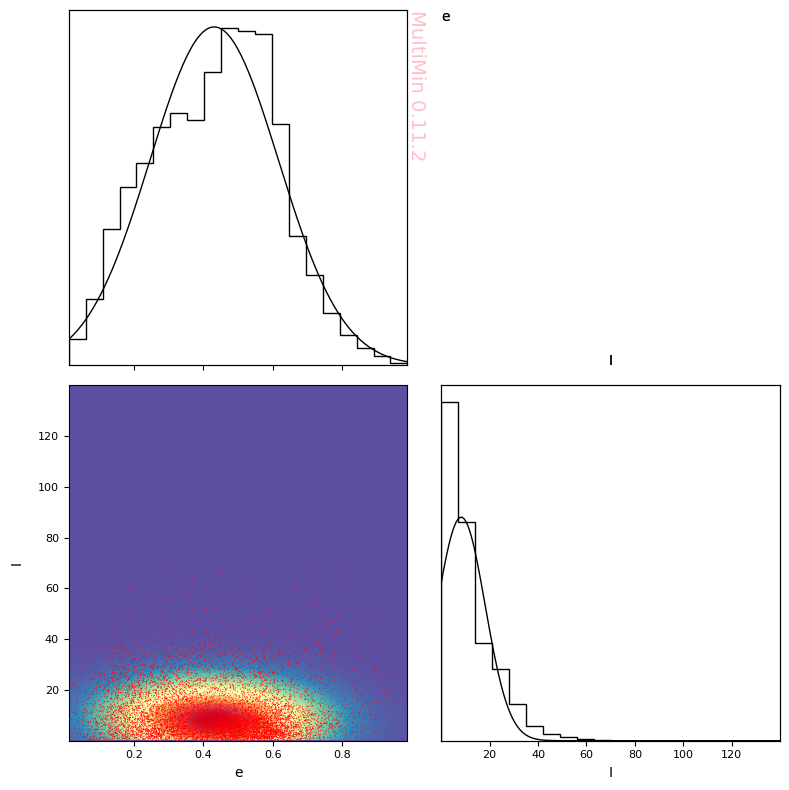

In [17]:
data_neas_ei=np.array(df_neas[["e","i"]])
F_ei_1 = mn.FitMoG(data=data_neas_ei, ngauss=1, domain=[[0,1], [0, 180]])
F_ei_1.fit_data(progress=False)
print(f"-log(L)/N = {F_ei_1.solution.fun/len(data_neas_ei)}")

properties=["e","I"]
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_ei_1.plot_fit(properties=properties,sargs=sargs,figsize=4,marginals=True)
plt.savefig(f'gallery/{figprefix}_fit_result_ei_1gauss.png')

### Fitting three variables: $q, e, I$

Let's extract first the data:

In [18]:
data_neas_qei = np.array(df_neas[["q","e","i"]])

Let's plot the original data:

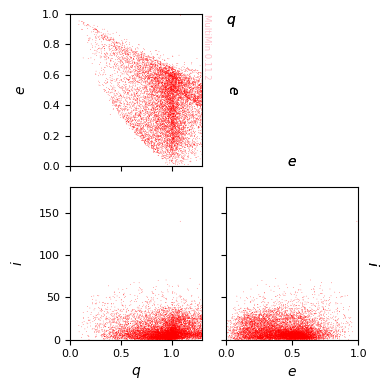

In [19]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

G = mn.MultiPlot(properties, figsize=2)
sargs = dict(s=0.2, edgecolor='None', color='r')
scatter = G.sample_scatter(data_neas_qei, **sargs)
plt.savefig(f'gallery/{figprefix}_data_neas_qei.png')


Now let's try to fit this data using truncated multivariate distribution:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Domain: [[0, 1.3], [0, 1.0], [0, 180]]
Log-likelihood per point (-log L/N): 143.82266197121922


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 1.4659969806671143 seconds
-log(L)/N = -0.7355306439187119


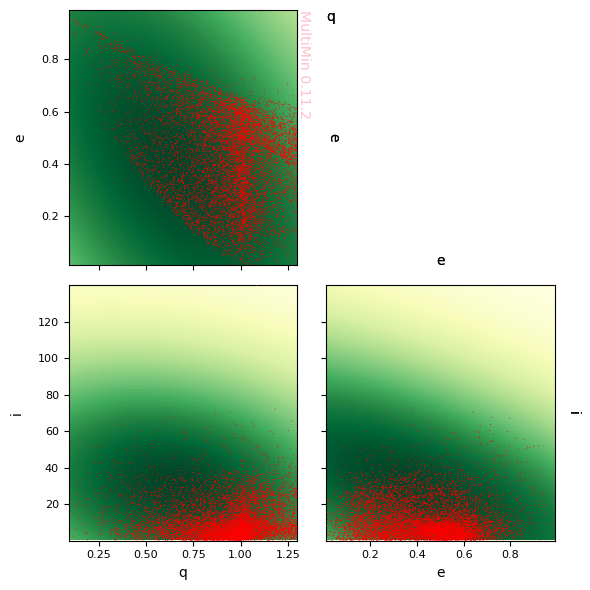

In [20]:
fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=1, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.fit_data(progress="tqdm", normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

properties=["q","e","i"]
pargs=dict(cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    sargs=sargs,
    pargs=pargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_simple.png')

As you see, without information the fit is not too successful. We will try a different approach.

**Initial parameters from partial fits.** The 1-Gaussian fit in (q,e,i) often misses the q–e correlation when started from generic initial values. We use the three 2D fits (F_qe_1, F_qi_1, F_ei_1) to build initial means, sigmas, and correlations for the full 3D fit: each mean/sigma is averaged over the two partial fits that contain that variable; each correlation comes from the single partial fit that contains that pair.

In [21]:
# Initial (mus, sigmas, rhos) from partial fits F_qe_1, F_qi_1, F_ei_1 (vars: 0=q, 1=e, 2=i)
mu_q = (F_qe_1.mog.mus[0, 0] + F_qi_1.mog.mus[0, 0]) / 2
mu_e = (F_qe_1.mog.mus[0, 1] + F_ei_1.mog.mus[0, 0]) / 2
mu_i = (F_qi_1.mog.mus[0, 1] + F_ei_1.mog.mus[0, 1]) / 2
sigma_q = (F_qe_1.mog.sigmas[0, 0] + F_qi_1.mog.sigmas[0, 0]) / 2
sigma_e = (F_qe_1.mog.sigmas[0, 1] + F_ei_1.mog.sigmas[0, 0]) / 2
sigma_i = (F_qi_1.mog.sigmas[0, 1] + F_ei_1.mog.sigmas[0, 1]) / 2
rho_qe = float(F_qe_1.mog.rhos[0, 0])
rho_qi = float(F_qi_1.mog.rhos[0, 0])
rho_ei = float(F_ei_1.mog.rhos[0, 0])

fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=1, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)
#fit_qei.set_bounds(boundsm=((0.8, 1.2), (0.0, 1.0), (0.0, 15.0)))
fit_qei.fit_data(progress="tqdm", normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Domain: [[0, 1.3], [0, 1.0], [0, 180]]
Log-likelihood per point (-log L/N): 143.82266143089612


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 0.5155620574951172 seconds
-log(L)/N = -2.3983401612611557


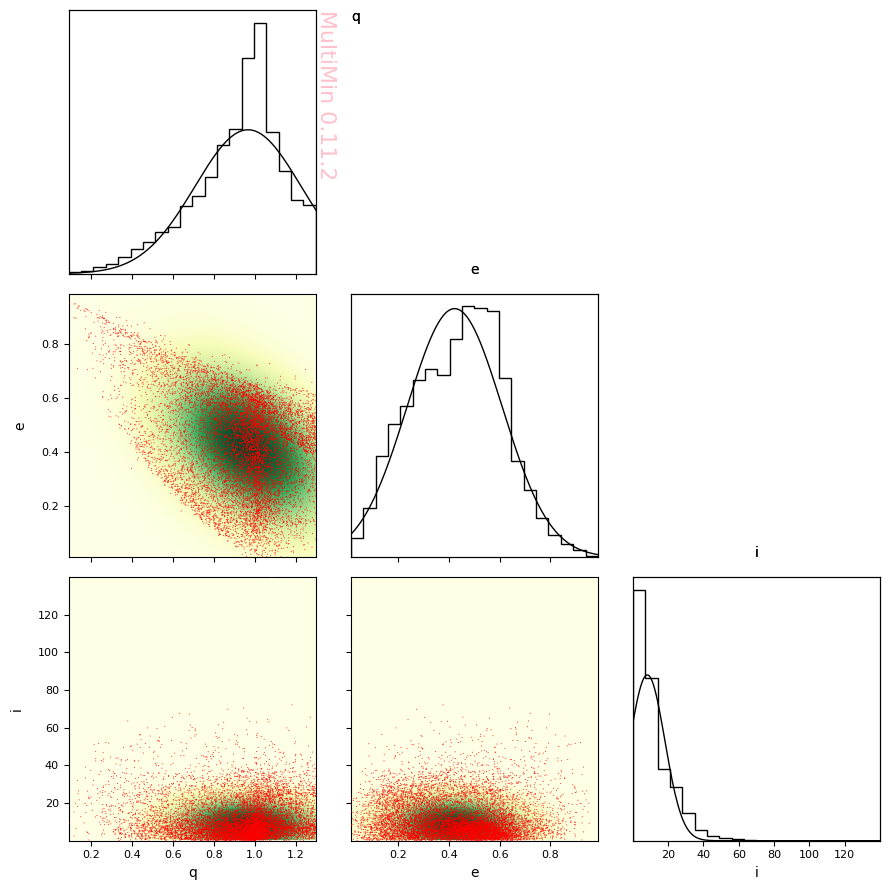

In [22]:
properties=["q","e","i"]
pargs=dict(cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    pargs=pargs,
    sargs=sargs,
    figsize=3,
    marginals=True
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_feed.png')

Much better!

Let's try with more gaussians:

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 3
Number of dimensions: 15
Number of samples: 10000
Domain: [[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]]
Log-likelihood per point (-log L/N): 338.17600944753315


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 10.4010009765625 seconds


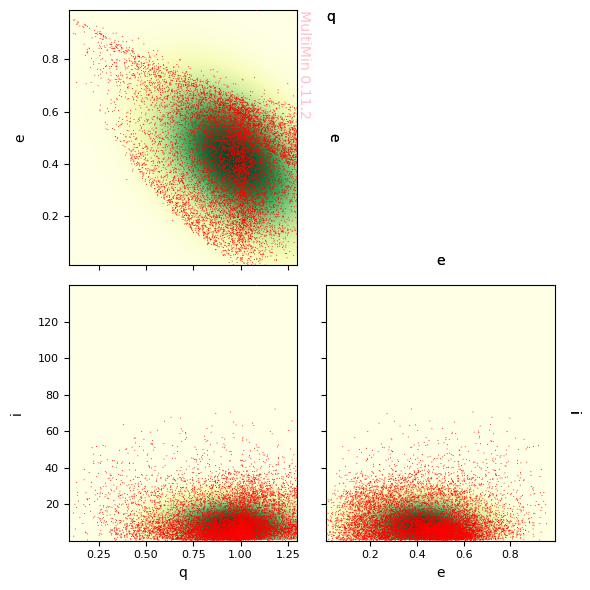

In [23]:
fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=5, domain=[[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]])

fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)

fit_qei.fit_data(progress="tqdm")
G=fit_qei.plot_fit(
    properties=properties,
    pargs=pargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_ngauss.png')

The problem is that the fit is not converging to a good representation of the distribution.

### Transforming data

Orbital elements such as $q$, $e$, and $i$ live in **finite intervals** (e.g. $q \in [0, q_{\max}]$, $e \in [0, 1)$, $i \in [0, \pi]$), while the MoG is defined on the whole real line. To fit a normal mixture on unbounded variables we first map each bounded variable to an unbounded one via a **logistic-type (log-odds) transformation** (see e.g. the *manuscript-neoflux* formalism).

For a variable $x \in (0, x_{\max})$, define the **unbound** variable:

$$u = \log\left(\frac{x/x_{\max}}{1 - x/x_{\max}}\right)$$

so that $u \in (-\infty, +\infty)$. The inverse map is:

$$x = \frac{x_{\max}}{1 + \exp(-u)}$$

In the notebook we use this with $q_{\max}=1.35$ au, $e_{\max}=1$, $i_{\max}=\pi$ to obtain unbound variables $(Q, C, I)$. Fitting the MoG in $(Q, C, I)$ and then transforming back preserves normalization and often improves conditioning; the same transformation is used in the manuscript for the NEO flux formalism.

Transform variables to an unbounded scale for fitting (e.g. with `Util.t_if` / `f2u`):

In [24]:
scales=[1.35,1.00,180.0]
udata=np.zeros_like(data_neas_qei)
for i in range(len(data_neas_qei)):
    udata[i]=mn.Util.t_if(data_neas_qei[i],scales,mn.Util.f2u)

Visualize the data with **MultiPlot** (scatter on pairwise panels):

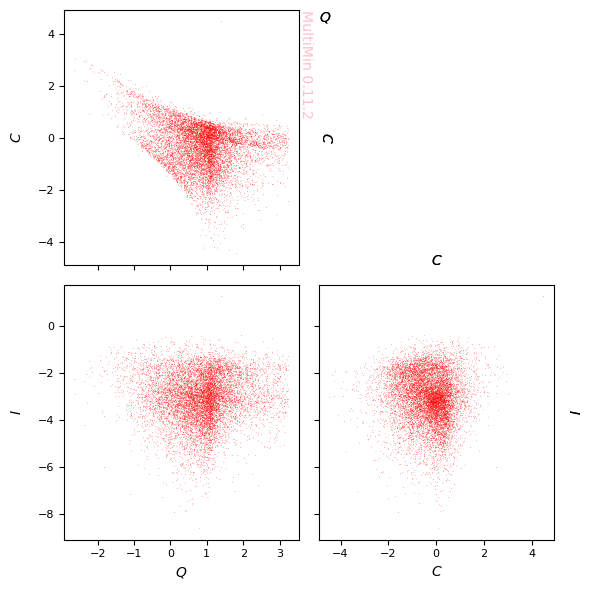

In [25]:
properties=dict(
    Q=dict(label=r"$Q$",range=None),
    E=dict(label=r"$C$",range=None),
    I=dict(label=r"$I$",range=None),
)
G=mn.MultiPlot(properties,figsize=3)

sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.sample_scatter(udata,**sargs)

plt.savefig('gallery/indepth_data_scatter_QCI.png')


The same idea (initial parameters from partial fits) can be reused for multi-component fits below.

You can also show 2D histograms on the panels:

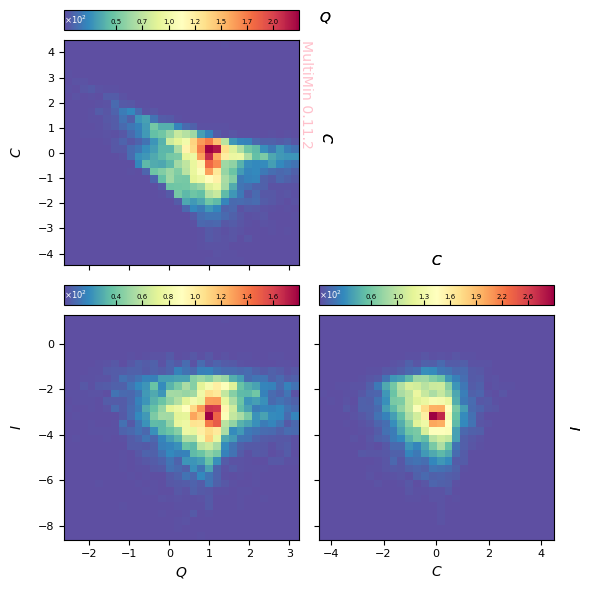

In [26]:
G=mn.MultiPlot(properties,figsize=3)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.sample_hist(udata,colorbar=True,**hargs)

plt.savefig('gallery/multimin_indepth_2.png')


Create the fitter (e.g. one Gaussian, three variables):

In [27]:
F=mn.FitMoG(data=udata, ngauss=1)

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Log-likelihood per point (-log L/N): 14.01292420165598


The fitter holds an initial MoG that will be optimized:

In [28]:
print(F.mog)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.5, 0.5, 0.5]]
    Standard deviations (σ): [[1.0000000000000002, 1.0000000000000002, 1.0000000000000002]]
    Correlation coefficients (ρ): [[0.5, 0.5, 0.5]]

    Covariant matrices (Σ): 
        [[[1.0000000000000004, 0.5000000000000002, 0.5000000000000002], [0.5000000000000002, 1.0000000000000004, 0.5000000000000002], [0.5000000000000002, 0.5000000000000002, 1.0000000000000004]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.5, 0.5, 0.5, 1.0000000000000004, 0.5000000000000002, 0.5000000000000002, 1.0000000000000004, 0.5000000000000002, 1.0000000000000004]
        With std. and correlations (10):
            [p1,μ1_1,μ1_2,μ1_3,σ1_1,σ1_2,σ1_3,ρ1_12,ρ1_13,ρ1_23]
            [1.0, 0.5, 0.5, 0.5, 1.0000000000000002, 1.0000000000000002, 1.000

Run the minimization:

In [29]:
t = mn.Util.el_time(0)
F.fit_data(verbose=False,progress="tqdm")
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(udata)}")

Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 0.21823716163635254 seconds
Elapsed time since last call: 218.496 ms
-log(L)/N = 3.95585372599441


Inspect the fitted MoG:

In [30]:
print(F.mog)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8605729678122919, -0.3384122690377656, -3.0757098168746153]]
    Standard deviations (σ): [[0.8407250580859433, 0.8684129810087118, 1.0693770849265927]]
    Correlation coefficients (ρ): [[-0.30984044642884734, 0.023097072434971496, -0.0645086173249525]]

    Covariant matrices (Σ): 
        [[[0.7068186232936128, -0.2262134421968911, 0.02076547174999843], [-0.2262134421968911, 0.7541411055844373, -0.05990663334136546], [0.02076547174999843, -0.05990663334136546, 1.143567349766097]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8605729678122919, -0.3384122690377656, -3.0757098168746153, 0.7068186232936128, -0.2262134421968911, 0.02076547174999843, 0.7541411055844373, -0.05990663334136546, 1.143567349766097]
        With std. and correlat

Plot the fit result (fitted sample + data scatter):

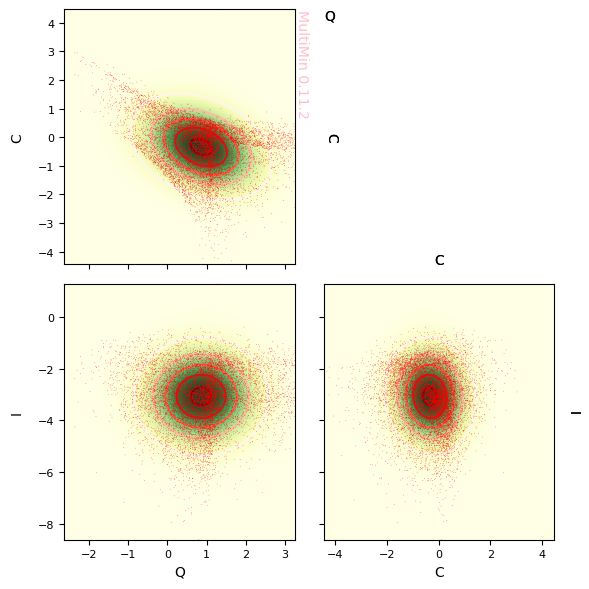

In [31]:
properties=["Q","C","I"]
pargs=dict(cmap='YlGn')
sargs=dict(s=0.2,edgecolor='None',color='r')
cargs=dict()
G=F.plot_fit(properties=properties,sargs=sargs,cargs=cargs,pargs=pargs,figsize=3)

plt.savefig(f'gallery/{figprefix}_indepth_fit_result_QCI.png')


Fitting can be time-consuming; you can save the result for later use:

In [32]:
F.save_fit(f"gallery/{figprefix}_fit-single.pkl",useprefix=False)

Load a previously saved fit (here or in another notebook):

In [33]:
F=mn.FitMoG(f"gallery/{figprefix}_fit-single.pkl")
print(F.mog)

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Log-likelihood per point (-log L/N): 3.95585372599441
Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8605729678122919, -0.3384122690377656, -3.0757098168746153]]
    Standard deviations (σ): [[0.8407250580859433, 0.8684129810087118, 1.0693770849265927]]
    Correlation coefficients (ρ): [[-0.30984044642884734, 0.023097072434971496, -0.0645086173249525]]

    Covariant matrices (Σ): 
        [[[0.7068186232936128, -0.2262134421968911, 0.02076547174999843], [-0.2262134421968911, 0.7541411055844373, -0.05990663334136546], [0.02076547174999843, -0.05990663334136546, 1.143567349766097]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8605729678122919, -0.3384122690377656, 

Fit with two Gaussian components for a better likelihood:

Loading a FitMoG object.
Number of gaussians: 2
Number of variables: 3
Number of dimensions: 6
Number of samples: 10000
Log-likelihood per point (-log L/N): 14.01292420165598


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 1.8731448650360107 seconds
Elapsed time since last call: 1.87351 s
-log(L)/N = 3.8404988081396585
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.36045330359049493, 0.639546696409505]
    Number of variables: 3
    Averages (μ): [[1.0026118181785064, 0.31827278999916386, -3.0946497216154105], [0.7708183357341977, -0.694124428098996, -3.074231719535267]]
    Standard deviations (σ): [[1.1014859873617338, 0.557152428345854, 0.9606825163856727], [0.6480012558609982, 0.7952126130037853, 1.123458227911257]]
    Correlation coefficients (ρ): [[-0.8124045633268461, -0.053973868624144994, 0.11595319201107457], [-0.32383437385601055, 0.10588533200328687, -0.13892503758133723]]

    Covariant matrices (Σ): 
        [[[1.2132713803542534, -0.498569099960419, -0.057113978169854765], [-0.498569099960419, 0.31041882841168195, 0.06206355142056842], [-0.057113978169854765, 0.06206355142056842, 0.9229108972891082]], [[0.4199056

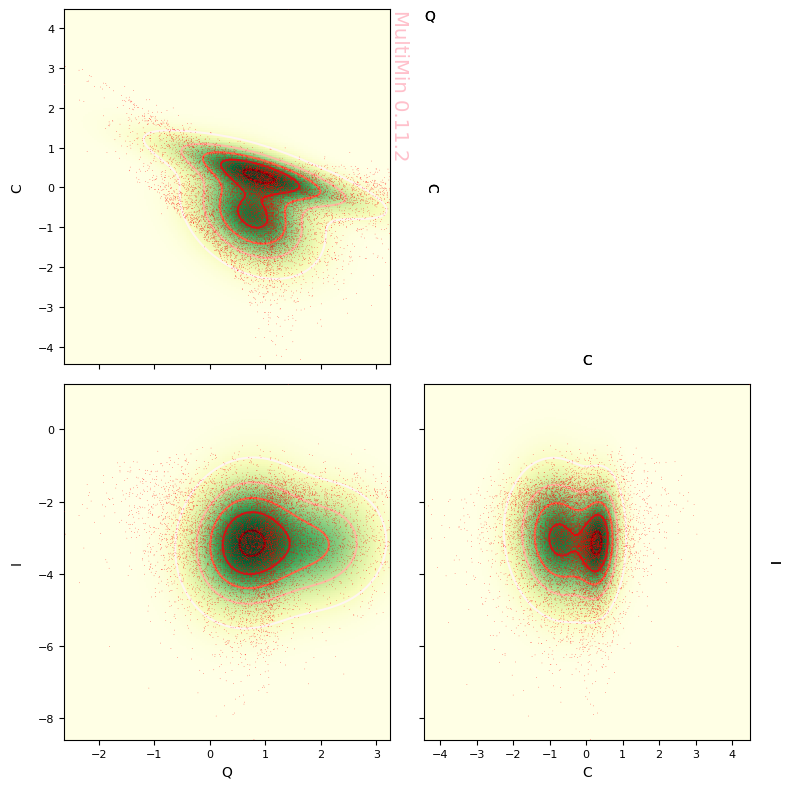

In [34]:
F=mn.FitMoG(data=udata, ngauss=2)

mn.Util.el_time(0)
F.fit_data(progress="tqdm")
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)

G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            pargs=dict(cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'),cargs=dict())
F.fig.savefig(f"gallery/{figprefix}_fit-multiple-{F.prefix}.png")

Using two components improves the fit (lower $-\log\mathcal{L}/N$).

You can set bounds on parameters (e.g. means, weights) to avoid unphysical solutions:

Loading a FitMoG object.
Number of gaussians: 2
Number of variables: 3
Number of dimensions: 6
Number of samples: 10000
Log-likelihood per point (-log L/N): 14.01292420165598


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 1.965381145477295 seconds
Elapsed time since last call: 1.9687 s
-log(L)/N = 3.839780193801437
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.3791114486700117, 0.6208885513299884]
    Number of variables: 3
    Averages (μ): [[1.0079402818976861, 0.3028131869437181, -3.1731636484271895], [0.7609936704853688, -0.7161784251019154, -3.0254743868039076]]
    Standard deviations (σ): [[1.0740783840394197, 0.549258710361431, 1.0223237355187231], [0.6529226408046985, 0.7954665923205886, 1.0913620699972684]]
    Correlation coefficients (ρ): [[-0.7969630548302042, -0.03387040888394299, 0.11767523609041185], [-0.34344704851069163, 0.10759475710072051, -0.08993338189331923]]

    Covariant matrices (Σ): 
        [[[1.153644375060731, -0.47016589002284326, -0.037191599797617415], [-0.47016589002284326, 0.3016851309079024, 0.0660770240512243], [-0.037191599797617415, 0.0660770240512243, 1.0451458202049562]], [[0.426307974

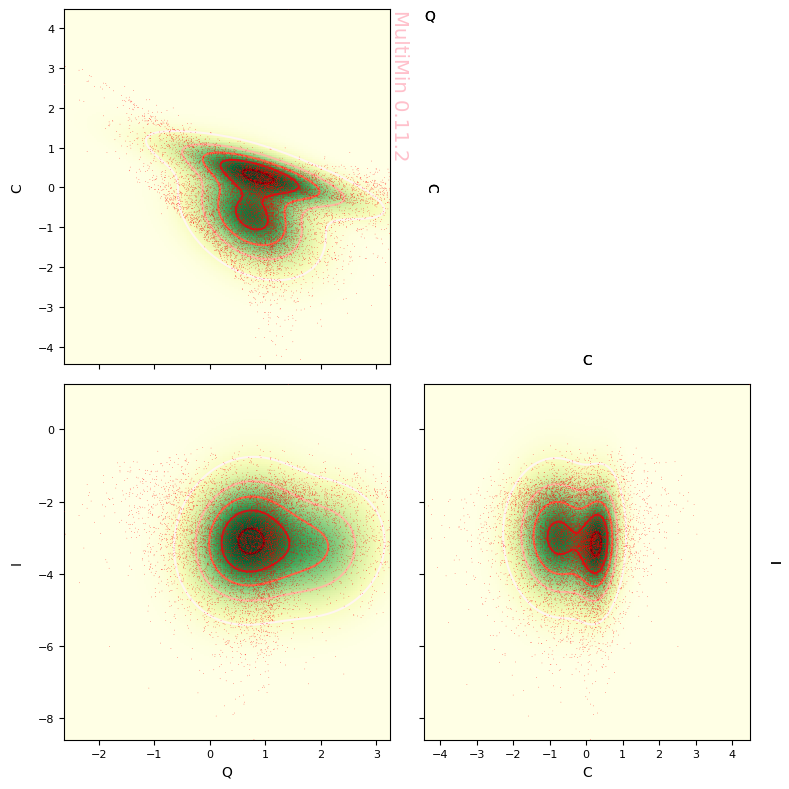

In [35]:
F=mn.FitMoG(data=udata, ngauss=2)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(udata,progress="tqdm",bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple-bounds.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)
G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            pargs=dict(cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'),cargs=dict())
F.fig.savefig("gallery/indepth_fit_2gauss_bounds_QCI.png")

Fitting with five Gaussians can capture more structure:

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 3
Number of dimensions: 15
Number of samples: 10000
Log-likelihood per point (-log L/N): 14.01292420165598


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 11.450128078460693 seconds
Elapsed time since last call: 11.4527 s
-log(L)/N = 3.712181108119883
Composition of ngauss = 5 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.1536229292340353, 0.24508497648076236, 0.20152138978789494, 0.17239440635356557, 0.22737629814374175]
    Number of variables: 3
    Averages (μ): [[1.241654882712849, -0.7591823186846021, -3.5439971483302286], [1.0000987827669763, -0.722003626795532, -2.61877548473865], [0.6970185650046709, 0.4103566811593673, -3.628249226971697], [1.6126251927313169, 0.01510379661213535, -3.125787945696569], [-0.004200227790548048, -0.536116672389023, -2.7494974986973046]]
    Standard deviations (σ): [[0.7391826401831176, 0.672439276529789, 1.3298972744243418], [0.3588412188805859, 0.633493222764143, 0.7704691777600665], [0.5703663173450618, 0.3567566676733523, 1.137790587649432], [0.8104834720316584, 0.2843111455885323, 0.7786488288329858], [0.7120676285689942, 1.2289709860878721, 

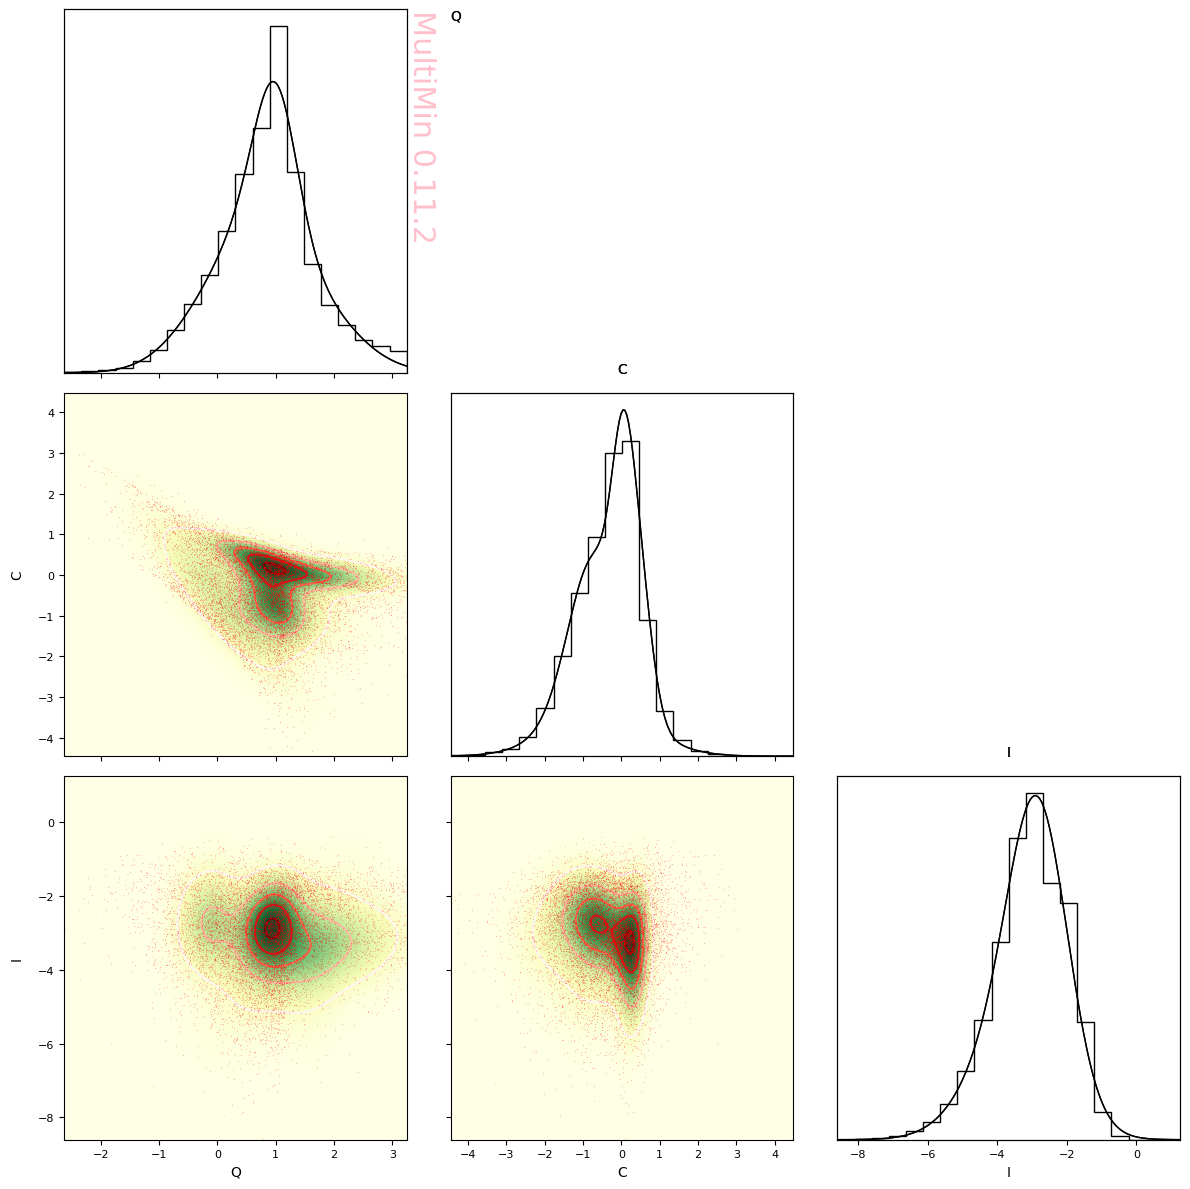

In [36]:
F=mn.FitMoG(data=udata, ngauss=5)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(progress="tqdm",bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/fit-multiple-bound_mus.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)
G=F.plot_fit(figsize=4,
            marginals=True,
            properties=["Q","C","I"],
            pargs=dict(cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'),cargs=dict())
F.fig.savefig(f"gallery/{figprefix}_fit_5gauss_bound_mus_QCI.png")

As you can see the fitting parameter $-\log{\cal L}$ is improved with respect to previous fit. 

Verify the fit by generating a sample from the fitted MoG and comparing to the data:

MixtureOfGaussians.rvs executed in 0.6000351905822754 seconds


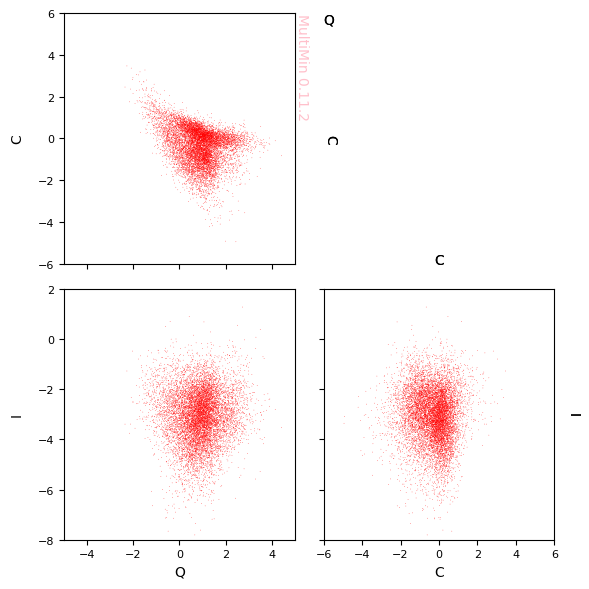

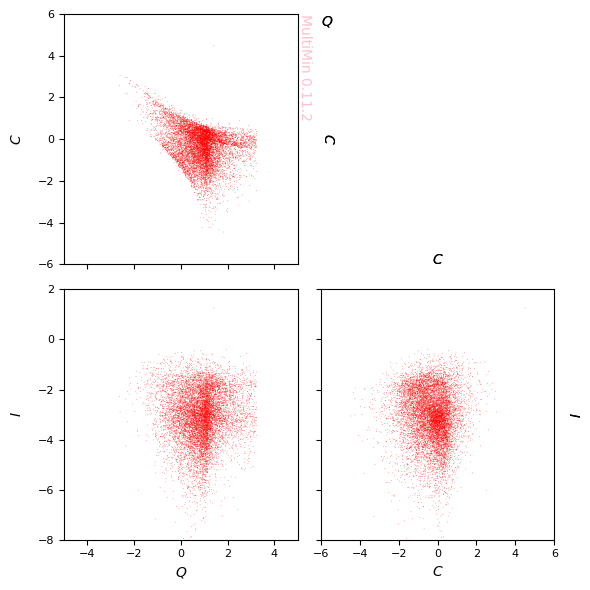

In [37]:
F.mog.plot_sample(N=len(F.data),
                  figsize=3,
                  properties=["Q","C","I"],ranges=[[-5,5],[-6,6],[-8,2]],
                  sargs=dict(s=0.2,edgecolor='None',color='r'))
G.fig.savefig(f"gallery/{figprefix}_sample_from_fit_20gauss_QCI.png")

properties=dict(
    Q=dict(label=r"$Q$",range=[-5,5]),
    C=dict(label=r"$C$",range=[-6,6]),
    I=dict(label=r"$I$",range=[-8,2]),
)
G=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.sample_scatter(udata,**sargs)

Let's compare them through its marginals:

MixtureOfGaussians.rvs executed in 0.562633752822876 seconds


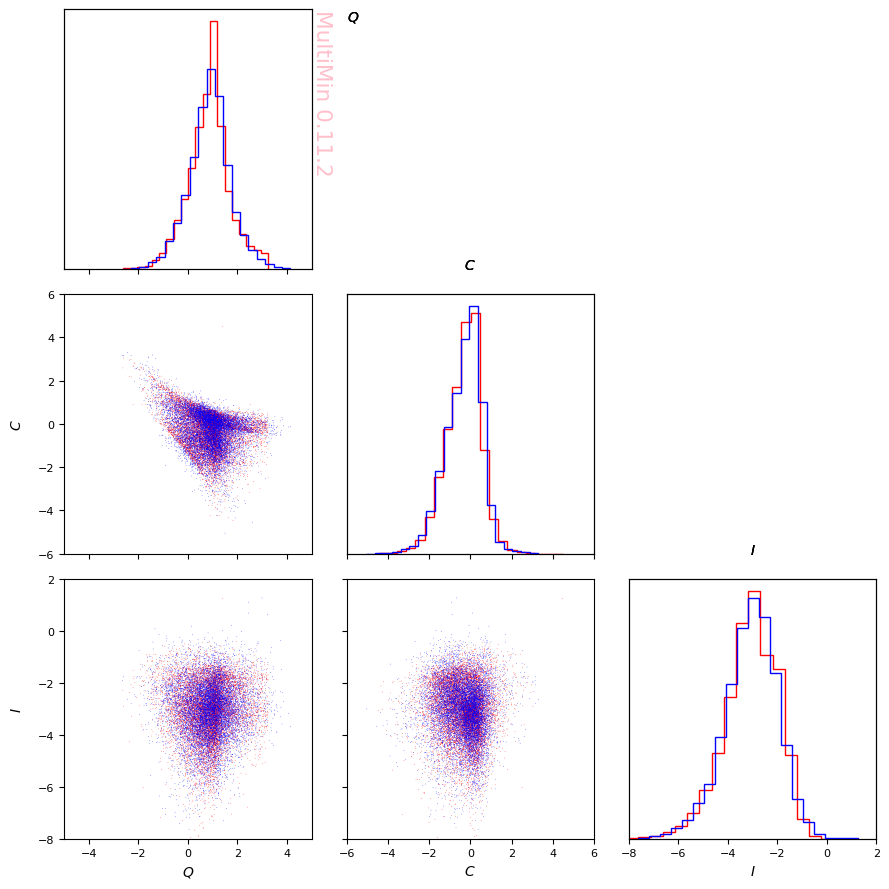

In [38]:
properties=dict(
    Q=dict(label=r"$Q$",range=[-5,5]),
    C=dict(label=r"$C$",range=[-6,6]),
    I=dict(label=r"$I$",range=[-8,2]),
)
G=mn.MultiPlot(properties,figsize=3,marginals=True)

sargs=dict(s=0.2,edgecolor='None',color='r',margs=dict(color='r'))
hist=G.sample_scatter(udata,**sargs)

sample = F.mog.rvs(len(udata))
sargs=dict(s=0.2,edgecolor='None',color='b',margs=dict(color='b'))
G.sample_scatter(sample,**sargs)

We can also check the original distribution:

In [39]:
scales=[1.35,1.00,180.0]
usample = F.mog.rvs(len(udata))
rsample=np.zeros_like(usample)
for i in range(len(usample)):
    rsample[i] = mn.Util.t_if(usample[i], scales, mn.Util.u2f)

MixtureOfGaussians.rvs executed in 0.5577900409698486 seconds


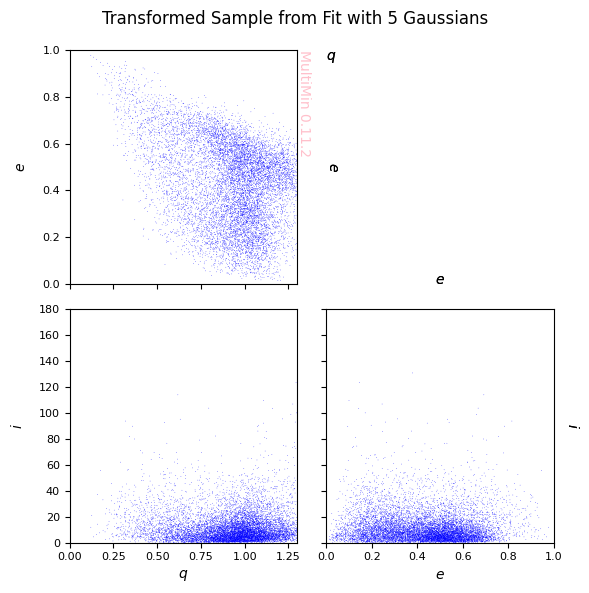

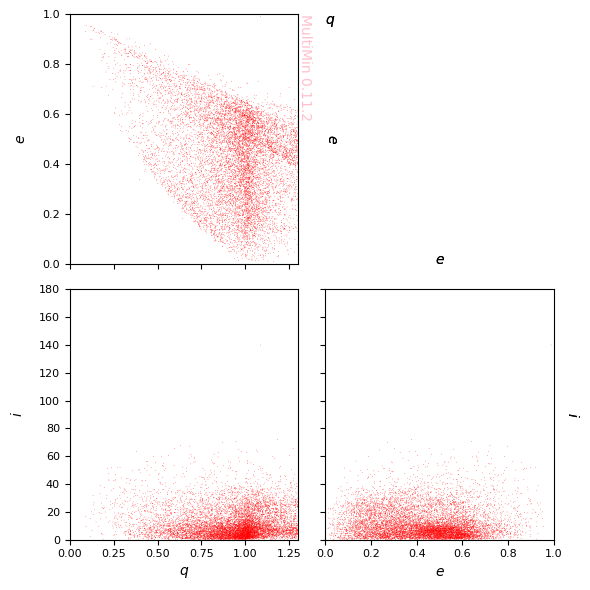

In [40]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

Gt=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='b')
scatter_transformed=Gt.sample_scatter(rsample,**sargs)
Gt.fig.suptitle(f"Transformed Sample from Fit with {F.ngauss} Gaussians")
Gt.fig.tight_layout()
Gt.fig.savefig(f"gallery/{figprefix}_sample_from_fit_ngauss_qei.png")

Go=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter_original=Go.sample_scatter(data_neas_qei,**sargs)

And their marginals:

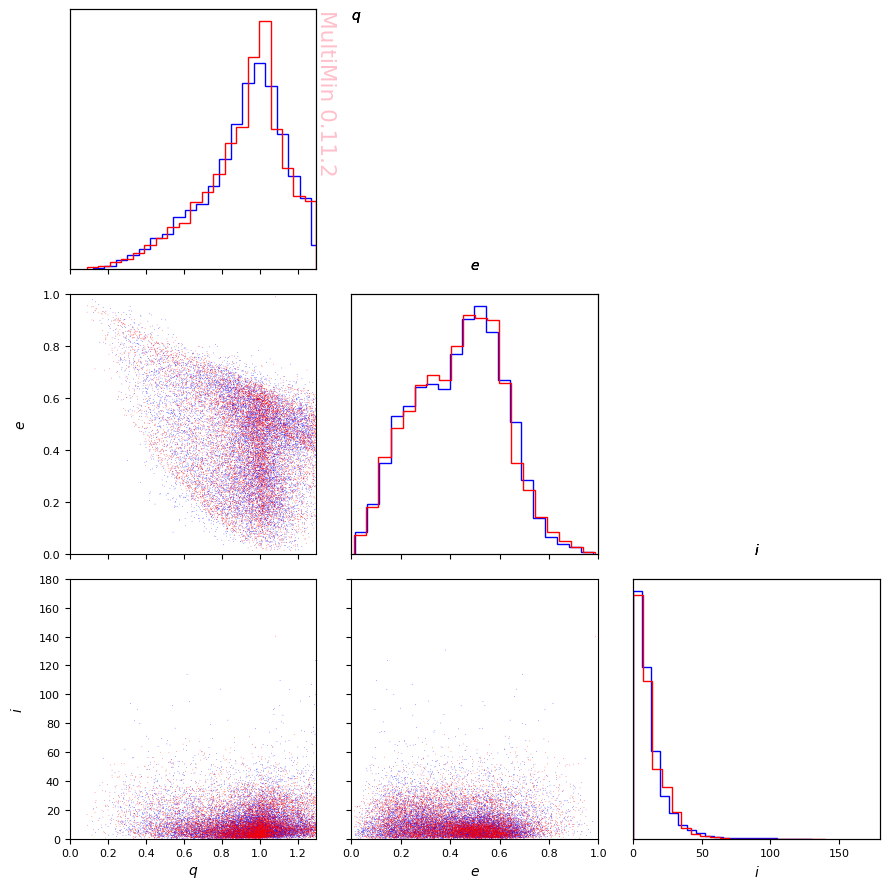

In [41]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

Gt=mn.MultiPlot(properties,figsize=3, marginals=True)
sargs=dict(s=0.2,edgecolor='None',color='b',margs=dict(color='b'))
scatter_transformed=Gt.sample_scatter(rsample,**sargs)

sargs=dict(s=0.2,edgecolor='None',color='r',margs=dict(color='r'))
scatter_original=Gt.sample_scatter(data_neas_qei,**sargs)

In [42]:
function, mog = F.mog.get_function(properties=properties)

from multimin import Util

def mog(X):

    mu1_q = 1.241655
    mu1_e = -0.759182
    mu1_i = -3.543997
    mu1 = [mu1_q, mu1_e, mu1_i]
    Sigma1 = [[0.546391, -0.100554, 0.640956], [-0.100554, 0.452175, -6e-06], [0.640956, -6e-06, 1.768627]]
    n1 = Util.nmd(X, mu1, Sigma1)

    mu2_q = 1.000099
    mu2_e = -0.722004
    mu2_i = -2.618775
    mu2 = [mu2_q, mu2_e, mu2_i]
    Sigma2 = [[0.128767, -0.095043, 0.065252], [-0.095043, 0.401314, -0.117555], [0.065252, -0.117555, 0.593623]]
    n2 = Util.nmd(X, mu2, Sigma2)

    mu3_q = 0.697019
    mu3_e = 0.410357
    mu3_i = -3.628249
    mu3 = [mu3_q, mu3_e, mu3_i]
    Sigma3 = [[0.325318, -0.149053, -0.08388], [-0.149053, 0.127275, 0.093056], [-0.08388, 0.093056, 1.294567]]
    n3 = Util.nmd(X, mu3, Sigma3)

    mu4_q = 1.612625
    mu4_e = 0.015104
    mu4_i = -3.125788
    mu4 = [mu4_q, mu4_e, mu4_i]
    Sigma4 = [[0.656883, -0.070138, 0.073644], [-0.070138, 0.080833, 0.058404], [0.073644, 0.058404, 0.606294]]
    n4 = Util.nmd(X, mu

---

**MultiMin** - Multivariate Gaussian fitting

© 2026 Jorge I. Zuluaga